In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import (
        KFold,
    StratifiedKFold,
    cross_val_score,
    TimeSeriesSplit
)
from sklearn.datasets import (
    make_classification,
    make_regression
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

# 🎯 Modelos de Clasificación: Balanceados vs Desbalanceados  

Cuando trabajamos con **modelos de clasificación**, es importante analizar el balance de las clases en nuestros datos.  

## 📌 **¿Qué es un Dataset Balanceado?**  
Un **dataset balanceado** es aquel donde todas las clases tienen una cantidad similar de ejemplos.  
Ejemplo:  
- **Fraude (Clase 1)**: 50%  
- **No Fraude (Clase 0)**: 50%  

En este caso, el modelo aprende de manera equilibrada porque ambas clases están bien representadas.  

## 📌 **¿Qué es un Dataset Desbalanceado?**  
Un **dataset desbalanceado** es aquel donde una clase tiene muchos más ejemplos que la otra.  
Ejemplo:  
- **Fraude (Clase 1)**: 5%  
- **No Fraude (Clase 0)**: 95%  

En este caso, el modelo puede aprender a predecir siempre la clase mayoritaria (No Fraude) y obtener una precisión alta, pero sin realmente identificar los casos de fraude.  

## ⚠️ **Problemas del Desbalance de Clases**
1️⃣ El modelo puede aprender a ignorar la clase minoritaria.  
2️⃣ Métricas como la **precisión (accuracy)** pueden ser engañosas.  
3️⃣ Puede generar predicciones poco útiles en la práctica.  

## ✅ **Soluciones para el Desbalance de Clases**
1️⃣ **Muestreo (Resampling)**  
   - **Oversampling**: Aumentar la cantidad de ejemplos en la clase minoritaria.  
   - **Undersampling**: Reducir la cantidad de ejemplos en la clase mayoritaria.  

2️⃣ **Ajustar Ponderaciones**  
   - Asignar un peso mayor a la clase minoritaria para que el modelo la considere más importante.  
   - (hay un parametro llamado class_weight en scikit-learn)

3️⃣ **Elegir Métricas Apropiadas**  
   - En lugar de accuracy, usar métricas como **F1-score, Recall o AUC-ROC**.  

---


📌 Reporte antes de balancear:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       190
         1.0       0.00      0.00      0.00        10

    accuracy                           0.94       200
   macro avg       0.47      0.50      0.49       200
weighted avg       0.90      0.94      0.92       200


📌 Reporte después de balancear con SMOTE:
              precision    recall  f1-score   support

         0.0       0.95      0.73      0.82       190
         1.0       0.05      0.30      0.09        10

    accuracy                           0.70       200
   macro avg       0.50      0.51      0.46       200
weighted avg       0.91      0.70      0.79       200



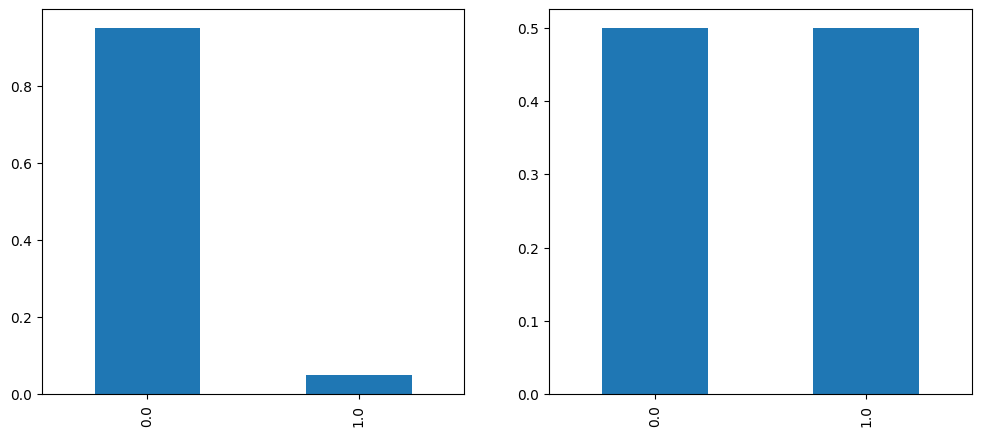

In [ ]:
# 🔹 Simulación de un dataset desbalanceado
np.random.seed(42)
n_samples = 1000
clase_mayoritaria = np.zeros(int(n_samples * 0.95))  # 95% clase 0
clase_minoritaria = np.ones(int(n_samples * 0.05))   # 5% clase 1
y = np.concatenate([clase_mayoritaria, clase_minoritaria])

# Variables aleatorias asociadas a cada clase
X = np.random.rand(n_samples, 2)

# Separar datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 🔹 Modelo en dataset desbalanceado
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Resultados antes de balancear
print("📌 Reporte antes de balancear:")
print(classification_report(y_test, y_pred))

# 🔹 Aplicar SMOTE para balancear
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# 🔹 Modelo en dataset balanceado
clf_bal = RandomForestClassifier(random_state=42)
clf_bal.fit(X_train_bal, y_train_bal)
y_pred_bal = clf_bal.predict(X_test)

# Resultados después de balancear
print("\n📌 Reporte después de balancear con SMOTE:")
print(classification_report(y_test, y_pred_bal))

# 🔹 Visualización del dataset antes y después de balancear
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
pd.Series(y_train).value_counts(1).plot(kind='bar', ax= axes[0])

pd.Series(y_train_bal).value_counts(1).plot(kind='bar', ax= axes[1])

plt.show()


# 🎯 Métricas de Evaluación en Modelos de Clasificación  

Al evaluar modelos de clasificación, es importante elegir las métricas adecuadas según la distribución de las clases en el dataset.  

## 📌 **Métricas para Datasets Balanceados**  
Cuando las clases están equilibradas, podemos usar métricas tradicionales como:  

1️⃣ **Accuracy (Precisión Global)**  
   - Mide el porcentaje de predicciones correctas.  
   - **Fórmula:**  

   $$  
   Accuracy = \frac{TP + TN}{TP + TN + FP + FN}  
   $$  

   - **Útil cuando las clases tienen proporciones similares.**  
   - 🚨 **Problema:** En datasets desbalanceados, puede ser engañosa.  

2️⃣ **ROC-AUC (Área Bajo la Curva ROC)**  
   - Mide la capacidad del modelo para separar clases correctamente.  
   - Valores cercanos a **1** indican un buen modelo.  

3️⃣ **Matriz de Confusión**  
   - Tabla que muestra los verdaderos positivos (**TP**), falsos positivos (**FP**), verdaderos negativos (**TN**) y falsos negativos (**FN**).  
   - Permite entender los errores del modelo.  

---

## 📌 **Métricas para Datasets Desbalanceados**  
Cuando las clases están desbalanceadas, **accuracy** deja de ser útil, por lo que usamos otras métricas:  

1️⃣ **Precision (Precisión por Clase)**  
   - Mide cuántas de las predicciones positivas fueron realmente correctas.  
   - **Fórmula:**  

   $$  
   Precision = \frac{TP}{TP + FP}  
   $$  

   - **Útil cuando los falsos positivos son costosos (ej: detección de fraude).**  

2️⃣ **Recall (Sensibilidad o Tasa de Verdaderos Positivos)**  
   - Mide cuántos de los casos positivos reales fueron detectados por el modelo.  
   - **Fórmula:**  

   $$  
   Recall = \frac{TP}{TP + FN}  
   $$  

   - **Útil cuando los falsos negativos son críticos (ej: diagnóstico de cáncer).**  

3️⃣ **F1-Score (Equilibrio entre Precisión y Recall)**  
   - Promedio armónico de Precision y Recall.  
   - **Fórmula:**  

   $$  
   F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}  
   $$  

   - **Útil cuando queremos un balance entre Precision y Recall.**  

4️⃣ **Average Precision (AP) - Precisión Promedio**  
   - Calcula el área bajo la curva **Precision-Recall** (PR AUC).  
   - Se obtiene integrando la precisión a lo largo de todos los valores de recall.  
   - **Fórmula:**  

   $$  
   AP = \sum_{n} (R_n - R_{n-1}) P_n  
   $$  

   donde \( P_n \) y \( R_n \) son la precisión y recall en el punto \( n \) de la curva.  

   - **Útil cuando queremos evaluar la calidad del ranking de predicciones en datasets desbalanceados.**  


🔹 Accuracy: 0.94
🔹 Precision: 0.88
🔹 Recall: 0.58
🔹 F1-Score: 0.70
🔹 ROC-AUC: 0.90
🔹 Average Precision (AP): 0.81


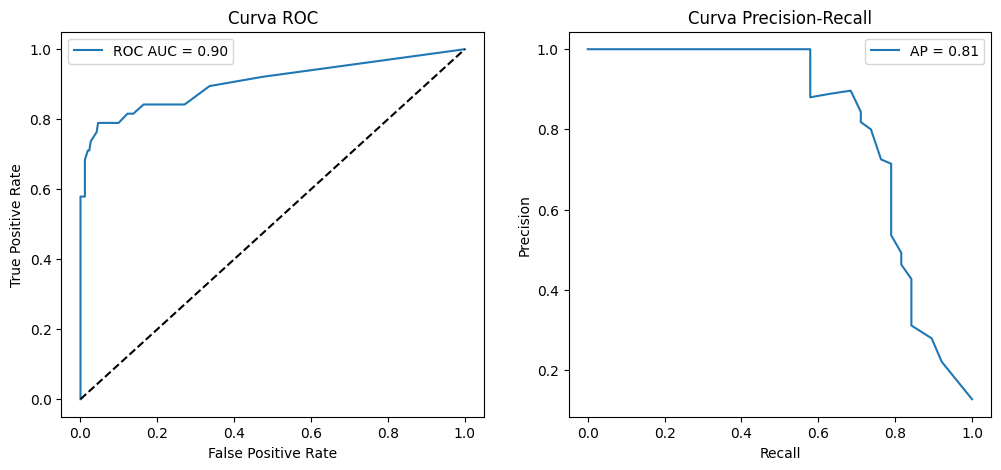

In [ ]:
# 📌 Generamos un dataset de ejemplo desbalanceado
X, y = make_classification(n_samples=1000, n_features=10, weights=[0.9, 0.1], random_state=42)

# Dividimos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenamos un modelo de clasificación
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Hacemos predicciones
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

# 📊 Cálculo de métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

# 📌 Mostramos los valores de las métricas
print(f"🔹 Accuracy: {accuracy:.2f}")
print(f"🔹 Precision: {precision:.2f}")
print(f"🔹 Recall: {recall:.2f}")
print(f"🔹 F1-Score: {f1:.2f}")
print(f"🔹 ROC-AUC: {roc_auc:.2f}")
print(f"🔹 Average Precision (AP): {average_precision:.2f}")

# 📊 Graficamos las curvas ROC y Precision-Recall
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
ax[0].plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
ax[0].plot([0, 1], [0, 1], 'k--')  # Línea de referencia
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("Curva ROC")
ax[0].legend()

# Curva Precision-Recall
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
ax[1].plot(recall_vals, precision_vals, label=f"AP = {average_precision:.2f}")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_title("Curva Precision-Recall")
ax[1].legend()

plt.show()


# 📊 Métricas de Evaluación en Modelos de Regresión  

Cuando entrenamos un modelo de **regresión** (es decir, un modelo que predice valores numéricos en lugar de categorías), necesitamos métricas para evaluar qué tan precisas son sus predicciones.  

---

## 🔹 **Métricas según la Escala del Target**  

### 📌 1️⃣ **Métricas útiles cuando la escala del target NO varía mucho**  
Si los valores del target son **similares en magnitud**, podemos usar métricas **en unidades originales**, como:  

#### ✅ **1.1 - Error Absoluto Medio (MAE - Mean Absolute Error)**  
Mide el error promedio en **valores absolutos**.  

$$
MAE = \frac{1}{n} \sum_{i=1}^{n} | y_i - \hat{y}_i |
$$

---

#### ✅ **1.2 - Error Cuadrático Medio (MSE - Mean Squared Error)**  
Penaliza más los errores grandes debido al cuadrado.  

$$
MSE = \frac{1}{n} \sum_{i=1}^{n} ( y_i - \hat{y}_i )^2
$$

---

#### ✅ **1.3 - Raíz del Error Cuadrático Medio (RMSE - Root Mean Squared Error)**  
Es más interpretable que el MSE, ya que está en las mismas unidades del target.  

$$
RMSE = \sqrt{MSE}
$$

---

#### ✅ **1.4 - R² (Coeficiente de Determinación)**  
Nos dice qué porcentaje de la variabilidad de los datos es explicada por el modelo.  

$$
R^2 = 1 - \frac{\sum ( y_i - \hat{y}_i )^2}{\sum ( y_i - \bar{y} )^2}
$$

---

### 📌 2️⃣ **Métricas útiles cuando la escala del target VARÍA mucho**  
Si los valores del target **tienen magnitudes muy diferentes**, es mejor usar métricas **relativas o robustas**, como:  

#### ✅ **2.1 - Error Porcentual Absoluto Medio (MAPE - Mean Absolute Percentage Error)**  
Expresa el error en **porcentaje**, lo que permite comparar modelos con diferentes escalas.  

$$
MAPE = \frac{100}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|
$$

⚠ **Desventaja**: No funciona bien si hay valores cercanos a **0** en el target.  

---

#### ✅ **2.2 - Error Porcentual Absoluto Medio Simétrico (SMAPE - Symmetric Mean Absolute Percentage Error)**  
Es una versión mejorada del MAPE que evita divisiones problemáticas.  

$$
SMAPE = \frac{100}{n} \sum_{i=1}^{n} \frac{| y_i - \hat{y}_i |}{(| y_i | + | \hat{y}_i |)/2}
$$

🔹 **Ventaja sobre MAPE**: No tiene problemas con valores cercanos a **0**.  

---

#### ✅ **2.3 - Mediana del Error Cuadrático (MedSE - Median Squared Error)**  
Es como el MSE, pero toma la **mediana en lugar del promedio**, haciéndolo más resistente a valores atípicos.  

$$
MedSE = \text{mediana} \left( ( y_i - \hat{y}_i )^2 \right)
$$

🔹 **Ventaja**: Es más **robusto a valores extremos**, útil en datos con **alta variabilidad**.  

---

#### ✅ **2.4 - R² Ajustado**  
Es una versión mejorada de R² para modelos con muchas variables.  

$$
R^2_{ajustado} = 1 - \left( \frac{(1 - R^2)(n - 1)}{n - p - 1} \right)
$$

Donde:  
- \( n \) es el número de observaciones  
- \( p \) es el número de predictores (variables independientes)  

---

✅ **¿Qué métrica usar?**  
- Si la escala de los datos **no varía mucho** → Usar **MAE, MSE, RMSE, R²**.  
- Si los valores del target son **muy diferentes entre sí** → Usar **MAPE, SMAPE, MedSE o R² ajustado**.  


🔹 Mean Absolute Error (MAE): 220.90
🔹 Mean Squared Error (MSE): 85725.73
🔹 Root Mean Squared Error (RMSE): 292.79
🔹 Mean Absolute Percentage Error (MAPE): 376.27%
🔹 Symmetric MAPE (SMAPE): 109.86%
🔹 Median Squared Error (MedSE): 19567.03
🔹 R-Squared (R²): 0.12
🔹 R-Squared Ajustado: 0.10


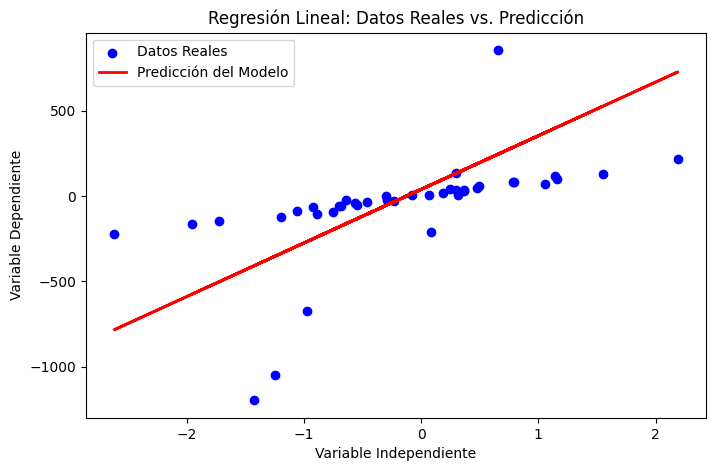

In [ ]:
# 📌 Generamos un dataset de ejemplo
X, y = make_regression(n_samples=200, n_features=1, noise=15, random_state=42)

# Simulamos un target con diferentes escalas (primera mitad del dataset más grande)
y[:50] *= 10

# Dividimos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos un modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Hacemos predicciones
y_pred = model.predict(X_test)

# 📊 Cálculo de métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # Cálculo manual del MAPE
smape = np.mean(2 * np.abs(y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))) * 100  # SMAPE
medse = np.median((y_test - y_pred) ** 2)  # Mediana del Error Cuadrático
r2_adjusted = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

# 📌 Mostramos los valores de las métricas
print(f"🔹 Mean Absolute Error (MAE): {mae:.2f}")
print(f"🔹 Mean Squared Error (MSE): {mse:.2f}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"🔹 Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"🔹 Symmetric MAPE (SMAPE): {smape:.2f}%")
print(f"🔹 Median Squared Error (MedSE): {medse:.2f}")
print(f"🔹 R-Squared (R²): {r2:.2f}")
print(f"🔹 R-Squared Ajustado: {r2_adjusted:.2f}")

# 📊 Graficamos los datos reales vs. predicciones
plt.figure(figsize=(8,5))
plt.scatter(X_test, y_test, color='blue', label="Datos Reales")
plt.plot(X_test, y_pred, color='red', linewidth=2, label="Predicción del Modelo")
plt.xlabel("Variable Independiente")
plt.ylabel("Variable Dependiente")
plt.title("Regresión Lineal: Datos Reales vs. Predicción")
plt.legend()
plt.show()


# 🎯 **Validación Cruzada (Cross Validation) en Machine Learning**  

Cuando entrenamos un modelo de Machine Learning, normalmente lo evaluamos separando los datos en **train (entrenamiento)** y **test (prueba)**. Sin embargo, si dividimos los datos solo una vez, podríamos obtener resultados **sesgados** o dependientes de la partición.  

Para solucionar esto, usamos **validación cruzada (cross validation, CV)**, una técnica que nos permite evaluar el rendimiento del modelo **de manera más confiable**.  

---

## 🔹 **¿Cómo funciona la Validación Cruzada?**  

En **validación cruzada**, los datos se dividen en **K partes (folds)** y el modelo se entrena **K veces**, usando una parte diferente para prueba en cada iteración.  

Ejemplo con **5 folds (K=5)**:  

1. Se divide el dataset en 5 partes.  
2. Se entrena el modelo en 4 partes y se evalúa en la parte restante.  
3. Se repite el proceso hasta que todas las partes hayan sido usadas como test.  
4. Se calcula el promedio de todas las métricas obtenidas.  

### 🎯 **Ventajas de Cross Validation:**  
✅ Usa **todos los datos** para entrenamiento y prueba, mejorando la evaluación.  
✅ Evita que los resultados dependan de una única división de datos.  
✅ Reduce el **sobreajuste (overfitting)** y mejora la **generalización**.  


![mutuamente_excluyente_1](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

https://scikit-learn.org/stable/_images/grid_search_cross_validation.png


---

## 🔹 **Tipos de Validación Cruzada**  

### 📌 **1️⃣ K-Fold Cross Validation**  
La más común. Se divide el dataset en **K partes** y se repite el entrenamiento K veces.  

🔹 **¿Cuándo usarlo?**  
✔️ Cuando los datos están bien distribuidos y no hay un problema de desbalanceo.  

---

### 📌 **2️⃣ Stratified K-Fold**  
Es una versión mejorada de K-Fold que **mantiene la proporción de clases** en cada fold.  

🔹 **¿Cuándo usarlo?**  
✔️ Cuando el dataset está **desbalanceado**, especialmente en clasificación.  

---

### 📌 **3️⃣ Time Series Split**  
Se usa en **series de tiempo**. Los datos se dividen respetando el **orden temporal**.  

🔹 **¿Cuándo usarlo?**  
✔️ Cuando los datos tienen una **secuencia temporal** (ventas, precios, clima).  
❌ **No debe mezclarse el futuro con el pasado**.  

---

✅ **¿Cuál elegir?**  
- Si tienes **datos balanceados** → Usa **K-Fold (K=5 o K=10 es común)**.  
- Si los datos están **desbalanceados** → Usa **Stratified K-Fold**.  
- Si los datos son **series de tiempo** → Usa **Time Series Split**.  


🔹 MAE en cada Fold (Regresión): [12.62498988 10.46567982  9.69885808  8.90394546 13.21486137]
🔹 MAE Promedio: 10.98
🔹 Accuracy en cada Fold (Clasificación): [0.8   0.9   0.85  0.875 0.8  ]
🔹 Accuracy Promedio: 0.85
🔹 MAE en cada Fold (Time Series Split): [10.320624302565058, 10.981627679731604, 11.977112150450477, 11.675479793038559, 8.204332150241772]
🔹 MAE Promedio (Time Series Split): 10.63


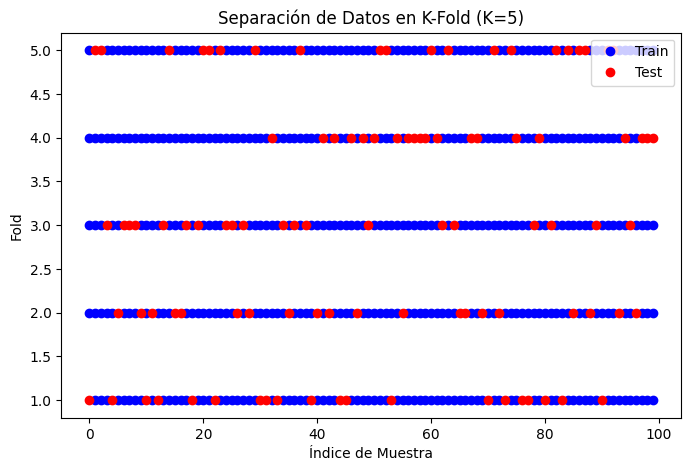

In [ ]:
# 📌 Ejemplo 1: K-Fold Cross Validation en Regresión
X_reg, y_reg = make_regression(n_samples=100, n_features=1, noise=15, random_state=42)
model_reg = LinearRegression()

# Aplicamos K-Fold con K=5
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = cross_val_score(model_reg, X_reg, y_reg, scoring='neg_mean_absolute_error', cv=kf)
print(f"🔹 MAE en cada Fold (Regresión): {-mae_scores}")
print(f"🔹 MAE Promedio: {-mae_scores.mean():.2f}")

# 📌 Ejemplo 2: Stratified K-Fold en Clasificación
X_clf, y_clf = make_classification(n_samples=200, n_features=5, n_classes=2, weights=[0.7, 0.3], random_state=42)
model_clf = make_pipeline(StandardScaler(), LogisticRegression())

# Aplicamos Stratified K-Fold con K=5
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = cross_val_score(model_clf, X_clf, y_clf, scoring='accuracy', cv=skf)
print(f"🔹 Accuracy en cada Fold (Clasificación): {accuracy_scores}")
print(f"🔹 Accuracy Promedio: {accuracy_scores.mean():.2f}")

# 📌 Ejemplo 3: Time Series Split en Series Temporales
tscv = TimeSeriesSplit(n_splits=5)
time_series_errors = []

for train_idx, test_idx in tscv.split(X_reg):
    X_train, X_test = X_reg[train_idx], X_reg[test_idx]
    y_train, y_test = y_reg[train_idx], y_reg[test_idx]

    model_reg.fit(X_train, y_train)
    y_pred = model_reg.predict(X_test)
    error = mean_absolute_error(y_test, y_pred)
    time_series_errors.append(error)

print(f"🔹 MAE en cada Fold (Time Series Split): {time_series_errors}")
print(f"🔹 MAE Promedio (Time Series Split): {np.mean(time_series_errors):.2f}")

# 📊 Graficamos la separación en folds
plt.figure(figsize=(8,5))
for i, (train_idx, test_idx) in enumerate(kf.split(X_reg), 1):
    plt.plot(train_idx, [i] * len(train_idx), 'bo', label="Train" if i == 1 else "")
    plt.plot(test_idx, [i] * len(test_idx), 'ro', label="Test" if i == 1 else "")

plt.xlabel("Índice de Muestra")
plt.ylabel("Fold")
plt.title("Separación de Datos en K-Fold (K=5)")
plt.legend()
plt.show()


# 🔍 **Grid Search CV: Optimizando Hiperparámetros**

Cuando entrenamos un modelo de machine learning, podemos ajustar ciertos **hiperparámetros** (valores que no se aprenden directamente de los datos) para mejorar el rendimiento del modelo.

Algunos ejemplos de hiperparámetros:  
✔️ Número de árboles en un **Random Forest** (`n_estimators`).  
✔️ Profundidad máxima en un **árbol de decisión** (`max_depth`).  
✔️ Valor de `C` en una **regresión logística**.  

## 🏆 ¿Cómo funciona GridSearchCV?
`GridSearchCV` prueba **todas las combinaciones posibles** de un conjunto de hiperparámetros y evalúa cuál es la mejor opción usando **validación cruzada (Cross Validation, CV)**.

### 📊 **Pasos de GridSearchCV**
1️⃣ **Define un modelo base** (ejemplo: `RandomForestClassifier`).  
2️⃣ **Especifica los hiperparámetros a probar** en un diccionario.  
3️⃣ **Configura `GridSearchCV`** indicando el modelo, los hiperparámetros y el número de particiones para validación cruzada (`cv`).  
4️⃣ **Ejecuta la búsqueda**: el algoritmo entrena el modelo para cada combinación y evalúa su rendimiento.  
5️⃣ **Selecciona la mejor combinación** de hiperparámetros según una métrica (ejemplo: `accuracy`).  

## 🎯 **¿Cuándo usar Grid Search?**
✅ Si tienes **pocos hiperparámetros importantes**, ya que `GridSearchCV` prueba todas las combinaciones posibles.  
✅ Si quieres asegurarte de encontrar **la mejor combinación de hiperparámetros** sin probarlas manualmente.  

💡 **Si el modelo tiene demasiados hiperparámetros, Grid Search puede ser muy costoso. En ese caso, se recomienda usar `RandomizedSearchCV`, que prueba combinaciones al azar en lugar de todas.** 🚀


In [ ]:
# 📌 Generamos datos de clasificación simulados
X, y = make_classification(n_samples=500, n_features=10, random_state=42)

# 📌 Dividimos los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📌 Definimos el modelo base
modelo = RandomForestClassifier(random_state=42)

# 📌 Definimos la rejilla de hiperparámetros a probar
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles
    'max_depth': [5, 10, None],      # Profundidad máxima
    'min_samples_split': [2, 5, 10]  # Mínimo de muestras para dividir un nodo
}

# 📌 Configuramos Grid Search con validación cruzada (cv=5)
grid_search = GridSearchCV(
    modelo, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1) # Paralelizar los procesos en los nucleos de la computadora

# 📌 Entrenamos el modelo con todas las combinaciones
grid_search.fit(X_train, y_train)

# 📌 Mostramos los mejores hiperparámetros encontrados
print("Mejores Hiperparámetros:", grid_search.best_params_)
print("Mejor Precisión en Validación:", grid_search.best_score_)

# 📌 Entrenamos el mejor modelo encontrado
mejor_modelo = grid_search.best_estimator_
print("Precisión en test:", mejor_modelo.score(X_test, y_test))


Mejores Hiperparámetros: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Mejor Precisión en Validación: 0.9349999999999999
Precisión en test: 0.94


### Ejercicio: Optimización de un Árbol de Decisión con GridSearchCV

En este ejercicio, trabajarás con un dataset de clasificación y seguirás una serie de pasos para evaluar su balance, seleccionar la métrica de evaluación adecuada y realizar una búsqueda de hiperparámetros utilizando `GridSearchCV`.

#### Pasos a seguir:

1. **Identificar si el dataset es balanceado o desbalanceado**
   - Calcula la distribución de clases en la variable objetivo.
   - Define un criterio para determinar si el dataset es balanceado (por ejemplo, si una clase representa menos del 20% del total, puede considerarse desbalanceado).

2. **Elegir la métrica de evaluación adecuada**

3. **Realizar una búsqueda de hiperparámetros con `GridSearchCV`**
   - Usa un `DecisionTreeClassifier` como estimador base.
   - Define un conjunto de hiperparámetros a ajustar (por ejemplo, `max_depth`, `min_samples_split`, `criterion`).
   - Configura el `GridSearchCV` con:
     - Un `cv` adecuado según el balance del dataset (estratificado si es desbalanceado).
     - Un `scoring` basado en la métrica elegida en el paso anterior.

Implementa cada uno de estos pasos en código para encontrar el mejor modelo posible según la métrica seleccionada.

```python
from sklearn.datasets import make_classification
# Generar dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2,
                           weights=[0.9, 0.1], random_state=42)
```


In [ ]:
from sklearn.datasets import make_classification
# Generar dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2,
                           weights=[0.9, 0.1], random_state=42)

# Separar datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Definir el modelo base
clf = DecisionTreeClassifier(random_state=42)

# Definir hiperparámetros a evaluar
grid_params = {
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Configurar la validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configurar GridSearchCV con la métrica f1-score para datos desbalanceados
grid_search = GridSearchCV(clf, grid_params, scoring='f1', cv=cv, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo y evaluación
y_pred = grid_search.best_estimator_.predict(X_test)
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       179
           1       1.00      0.52      0.69        21

    accuracy                           0.95       200
   macro avg       0.97      0.76      0.83       200
weighted avg       0.95      0.95      0.94       200

